In [5]:
import numpy as np
import xgboost as xgb
import shap

import matplotlib.pyplot as plt

In [6]:
def regression_adjustment(baseline, explicand, model, num_samples):
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples //= 2
    # Learn a model to explain the predictions of the original model
    synth_data = np.tile(baseline, (num_samples, 1))
    for idx in range(num_samples):
        # randomly choose a subset of features to mask
        sample_size = gen.integers(1, num_features, endpoint=True)
        chosen = gen.choice(range(num_features), sample_size, replace=False)
        # create masked input as combination of baseline and explicand
        synth_data[idx, chosen] = explicand[0, chosen]

    predictions = eval_model(synth_data)
    shap_model = xgb.XGBRegressor(n_estimators=100, max_depth=4).fit(synth_data, predictions)
    chosens = np.zeros((num_samples, num_features))

    # Estimate shapley values for the explicand with regression adjustment
    synth_data = np.tile(baseline, (num_samples, 1))
    for idx in range(num_samples):
        sample_size = gen.integers(1, num_features, endpoint=True)
        chosen = gen.choice(range(num_features), sample_size, replace=False)
        chosens[idx, chosen] = 1
        synth_data[idx, chosen] = explicand[0, chosen]

    predictions = eval_model(synth_data)
    adjustment = shap_model.predict(synth_data)
    adjustment_centered = adjustment - np.mean(adjustment)

    phi = np.zeros((2,num_features))
    num_values = np.zeros((2,num_features))
    for idx in range(num_samples):
        val = predictions[idx] - adjustment_centered[idx]
        for i in range(num_features):
            sign = 1 if chosens[idx,i] == 1 else 0
            phi[sign,i] += val
            num_values[sign,i] += 1

    phi /= num_values
    phi = phi[1] - phi[0]
    return phi

def kernel_shap(baseline, explicand, model, num_samples):
    eval_model = lambda X : model.predict(X)

    explainer = shap.KernelExplainer(eval_model, baseline)
    shap_values = explainer.shap_values(explicand, nsamples=num_samples)
    return shap_values

def shapley_sampling(baseline, explicand, model, num_samples):
    eval_model = lambda X : model.predict(X)
    explainer = shap.SamplingExplainer(eval_model, baseline)
    shap_values = explainer.shap_values(explicand, nsamples=num_samples)
    return shap_values

def tree_shap(baseline, explicand, model, num_samples):
    explainer = shap.TreeExplainer(model, baseline)
    shap_values = explainer.shap_values(explicand)
    return shap_values

def recycled_sampling(baseline, explicand, model, num_samples):
    eval_model = lambda X : model.predict(X)
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    synth_data = np.tile(baseline, (num_samples, 1))
    chosens = np.zeros((num_samples, num_features))
    for idx in range(num_samples):
        sample_size = gen.integers(1, num_features, endpoint=True)
        chosen = gen.choice(range(num_features), sample_size, replace=False)
        chosens[idx, chosen] = 1
        synth_data[idx, chosen] = explicand[0, chosen]
    predictions = eval_model(synth_data)
    phi = np.zeros(num_features)
    for i in range(num_features):
        included_indices = np.where(chosens[:,i] == 1)[0]
        included = predictions[included_indices].mean()
        excluded_indices = np.where(chosens[:,i] == 0)[0]
        excluded = predictions[excluded_indices].mean()
        phi[i] = included - excluded
    return phi

def uniform_sampling(baseline, explicand, model, num_samples):
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples_per_feature = (num_samples // num_features) // 2
    phi = np.zeros((1,num_features))
    for i in range(num_features):
        with_data = np.tile(baseline, (num_samples_per_feature, 1))
        without_data = np.tile(baseline, (num_samples_per_feature, 1))
        for idx in range(num_samples_per_feature):            
            sample_size = gen.integers(1, num_features, endpoint=True)
            chosen = gen.choice(range(num_features), sample_size, replace=False)
            if i not in chosen:
                chosen = np.append(chosen, i)
            # With i included
            with_data[idx, chosen] = explicand[0, chosen]
            if i in chosen:
                chosen = chosen[chosen != i]
            # Without i included
            without_data[idx, chosen] = explicand[0, chosen]
        with_vals = eval_model(with_data)
        without_vals = eval_model(without_data)
        preds = with_vals - without_vals
        learned_model = xgb.XGBRegressor(n_estimators=100, max_depth=4).fit(with_data, preds)
        adjustment = learned_model.predict(with_data)
        adjustment_centered = adjustment - np.mean(adjustment)
        phi[0,i] = np.mean(with_vals - without_vals)
    return phi

def regression_shap(baseline, explicand, model, num_samples):
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples_per_feature = (num_samples // num_features) // 2
    phi = np.zeros((1,num_features))
    for i in range(num_features):
        with_data = np.tile(baseline, (num_samples_per_feature, 1))
        without_data = np.tile(baseline, (num_samples_per_feature, 1))
        for idx in range(num_samples_per_feature):            
            sample_size = gen.integers(1, num_features, endpoint=True)
            chosen = gen.choice(range(num_features), sample_size, replace=False)
            if i not in chosen:
                chosen = np.append(chosen, i)
            # With i included
            with_data[idx, chosen] = explicand[0, chosen]
            if i in chosen:
                chosen = chosen[chosen != i]
            # Without i included
            without_data[idx, chosen] = explicand[0, chosen]
        with_vals = eval_model(with_data)
        without_vals = eval_model(without_data)
        X = np.concatenate((with_data, without_data))
        y = np.concatenate((with_vals, without_vals))
        learned_model = xgb.XGBRegressor(n_estimators=100, max_depth=4).fit(X, y)
        adjustment_with = learned_model.predict(with_data)
        adjustment_without = learned_model.predict(without_data)
        adjustment_with_centered = adjustment_with - np.mean(adjustment_with)
        adjustment_without_centered = adjustment_without - np.mean(adjustment_without)
        phi[0,i] = np.mean(with_vals - without_vals - adjustment_with_centered + adjustment_without_centered)
    return phi

def uniform_sampling_adjusted(baseline, explicand, model, num_samples):
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples_per_feature = (num_samples // num_features) // 2
    phi = np.zeros((1,num_features))
    for i in range(num_features):
        with_data = np.tile(baseline, (num_samples_per_feature, 1))
        without_data = np.tile(baseline, (num_samples_per_feature, 1))
        for idx in range(num_samples_per_feature):            
            sample_size = gen.integers(1, num_features, endpoint=True)
            chosen = gen.choice(range(num_features), sample_size, replace=False)
            if i not in chosen:
                chosen = np.append(chosen, i)
            # With i included
            with_data[idx, chosen] = explicand[0, chosen]
            if i in chosen:
                chosen = chosen[chosen != i]
            # Without i included
            without_data[idx, chosen] = explicand[0, chosen]
        with_vals = eval_model(with_data)
        without_vals = eval_model(without_data)
        preds = with_vals - without_vals
        learned_model = xgb.XGBRegressor(n_estimators=100, max_depth=4).fit(with_data, preds)
        adjustment = learned_model.predict(with_data)
        adjustment_centered = adjustment - np.mean(adjustment)
        phi[0,i] = np.mean(with_vals - without_vals - adjustment_centered)
    return phi


def uniform_sampling(baseline, explicand, model, num_samples):
    num_features = baseline.shape[1]
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples_per_feature = (num_samples // num_features) // 2
    phi = np.zeros((1,num_features))
    for i in range(num_features):
        with_data = np.tile(baseline, (num_samples_per_feature, 1))
        without_data = np.tile(baseline, (num_samples_per_feature, 1))
        for idx in range(num_samples_per_feature):            
            sample_size = gen.integers(1, num_features, endpoint=True)
            chosen = gen.choice(range(num_features), sample_size, replace=False)
            if i not in chosen:
                chosen = np.append(chosen, i)
            # With i included
            with_data[idx, chosen] = explicand[0, chosen]
            if i in chosen:
                chosen = chosen[chosen != i]
            # Without i included
            without_data[idx, chosen] = explicand[0, chosen]
        with_vals = eval_model(with_data)
        without_vals = eval_model(without_data)
        phi[0,i] = np.mean(with_vals - without_vals)
    return phi

algorithms = {
    #'Kernel SHAP': kernel_shap,
    'Sampling SHAP': shapley_sampling,
    #'Regression SHAP': regression_adjustment,
    #'Uniform' : uniform_sampling,
    #'Recycled' : recycled_sampling,
    #'Uniform Adjusted' : uniform_sampling_adjusted,
    #'Regression SHAP' : regression_shap
}

In [7]:
X, y = shap.datasets.communitiesandcrime()

# Train xgboost classifier
model = xgb.XGBRegressor(n_estimators=100, max_depth=4)
model.fit(X, y)
num_samples = 1000

eval_model = lambda X : model.predict(X)

baseline_idx = 100
explicand_idx = 10
baseline = X.iloc[baseline_idx].values.reshape(1, -1)
#baseline = np.zeros_like(baseline)
#baseline = X.mean(axis=0).values.reshape(1, -1)
explicand = X.iloc[explicand_idx].values.reshape(1, -1)
num_features = X.shape[1]

results = {}
sample_sizes = [200, 300, 500, 1000, 2000, 5000, 10000]
true_shap_values = tree_shap(baseline, explicand, model, num_samples)
for name, algorithm in algorithms.items():     
    results[name] = []

    for num_samples in sample_sizes:
        print(baseline.shape)
        print(explicand.shape)
        shap_values = algorithm(baseline, explicand, model, num_samples)
        error = ((shap_values - true_shap_values)**2).mean()
        results[name].append(error)

(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 75.41it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 54.22it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 41.19it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 29.32it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


(1, 101)
(1, 101)


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


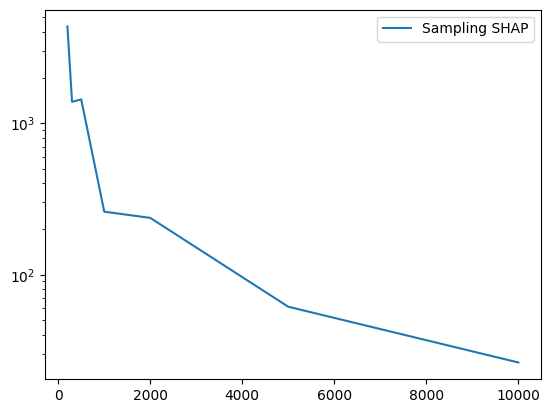

In [8]:
for name, errors in results.items():
    plt.plot(sample_sizes, errors, label=name)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--')
plt.yscale('log')
plt.legend()